In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from spatialsurf.utils.data_pp import spatial_pp
import numpy as np
from spatialsurf.utils.deconvolution import deconvolution
from spatialsurf.utils.calculate_cell_type_expression import calc_cell_type_expr
from spatialsurf.utils.cell_type_matching import cell_type_matching
import seaborn as sns
import matplotlib.pyplot as plt
from spatialsurf.utils.cell_type_visualization import celltype_visualization_ST
from spatialsurf.utils.pie_plot import pie_plot
from spatialsurf.models.wae import WAE
import torch
import torch.nn.functional as F
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

/opt/conda/envs/SURF_test/lib/python3.9/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/local/cuda/lib64:", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda/lib64:"
  warnings.warn(
/opt/conda/envs/SURF_test/lib/python3.9/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/root", R: "/root/github_code_test/tutorials"
  warnings.warn(
/opt/conda/envs/SURF_test/lib/python3.9/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda/lib64:", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/lib/R/lib:/usr

In [2]:
data_dir = 'Example_data/simulated_data/raw_data/'
save_dir = 'Example_data/simulated_data/pp_data/'
expr_path = data_dir + '/count.csv'
pos_path = data_dir + '/pos.csv'
barcodes_path = data_dir + 'barcodes.csv'
device_id = 0
num_workers = 0  # Windows: Recommended to set 'num_workers=0'; Linux/macOS: Recommended to set 'num_workers>0' (e.g., num_workers=1)

# 1. Read data

In [3]:
df_expr = pd.read_csv(expr_path)
df_pos = pd.read_csv(pos_path)
df_pos['x'] = df_pos['x'] - df_pos['x'].min()
df_pos['y'] = df_pos['y'] - df_pos['y'].min()
barcode = pd.read_csv(barcodes_path).iloc[:, 0].to_list()

# 2. Data preprocessing

### Function input
&nbsp;&nbsp;&nbsp;&nbsp;**df_expr**: (dataframe), column names: gene names, shape: (n_spots, n_genes). The gene expression of ST data. 
    
&nbsp;&nbsp;&nbsp;&nbsp;**df_pos**: (dataframe), column names: ‘x’, ‘y’, shape: (n_spots, 2). The position data of ST data.
    
&nbsp;&nbsp;&nbsp;&nbsp;**barcodes**: (list), len: n_spots. The barcodes of ST data.  

&nbsp;&nbsp;&nbsp;&nbsp;**save_dir**: (str). The directory to save the preprocessed data.
### Function output

&nbsp;&nbsp;&nbsp;&nbsp;**df_pp_data**: (dataframe), shape: (n_spots, (3 + n_genes)). The preprocessed ST data. The first three columns represent spot_id, x-coordinate, and y-coordinate, respectively. The remaining columns correspond to different genes.

In [4]:
df_pp_data = spatial_pp(df_expr=df_expr.copy(), df_pos=df_pos.copy(), barcodes=barcode.copy(), save_dir=save_dir)

/opt/conda/envs/SURF_test/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Data preprocessing begin...
Spots with no more than 100 gene counts are filtered out.
Genes present in all the spots are filtered out.
Genes detected in fewer than 5% of spots are filtered out.
Gene filtering begin...
2366 overdispersed genes remaining.
select the top 1000  most overdispersed genes by default.

Data preprocessing end.


# 3. Deconvolution 
 (To save time, here we just set epoch=20 to show the deconvolution process. To get better deconvolution results, it is recommended to set epoch=500.)  

### Function input
&nbsp;&nbsp;&nbsp;&nbsp;**df_data**: (dataframe), shape: (n_spots, (3 + n_genes)). The preprocessed ST data. The first three columns represent spot_id, x-coordinate, and y-coordinate, respectively. The remaining columns correspond to different genes.

&nbsp;&nbsp;&nbsp;&nbsp;**cell_type_num**: (list). The cell type number.

&nbsp;&nbsp;&nbsp;&nbsp;**spatial_model**: (str, 'square', 'hexagon', or 'others'). The parameter is dependent on the spatial mode of spots.

&nbsp;&nbsp;&nbsp;&nbsp;**save_dir_name**: (str). The name of the folders where to save the deconvolution results.

&nbsp;&nbsp;&nbsp;&nbsp;**device_id**: (int). The id of the gpu you want to use.

&nbsp;&nbsp;&nbsp;&nbsp;**num_epoch**: (int, default=500). The number of epochs to train the model.

&nbsp;&nbsp;&nbsp;&nbsp;**num_workers**: (int, default=0). Number of worker processes for data loading.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Windows: Recommended to set 'num_workers=0'  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Linux/macOS: Recommended to set 'num_workers>0' (e.g., num_workers=1)  
### Function output

&nbsp;&nbsp;&nbsp;&nbsp;**df_deconvolution_results**: (dataframe), shape: (n_spots, (cell type number + 3)). The deconvolution results of SURF.  

&nbsp;&nbsp;&nbsp;&nbsp;**df_beta**: (dataframe), shape: (cell_type_number, (n_genes + 1)). The deconvolved gene expressions of each cell type.

In [5]:
df_deconvolution_results, df_beta, dataloader = deconvolution(df_data=df_pp_data, cell_type_num=4, spatial_mode='square', save_dir_name='simulated_data', device_id=device_id, num_epoch=20, num_workers=num_workers)


Data organization...
Total_spot_num:800
Data organization completed.
begin time:2025-07-23_13-22-09

Deconvolution begin...
Epoch 1/20 completed
Epoch 2/20 completed
Epoch 3/20 completed
Epoch 4/20 completed
Epoch 5/20 completed
Epoch 6/20 completed
Epoch 7/20 completed
Epoch 8/20 completed
Epoch 9/20 completed
Epoch 10/20 completed
Epoch 11/20 completed
Epoch 12/20 completed
Epoch 13/20 completed
Epoch 14/20 completed
Epoch 15/20 completed
Epoch 16/20 completed
Epoch 17/20 completed
Epoch 18/20 completed
Epoch 19/20 completed
Epoch 20/20 completed
Deconvolution completed


In [6]:
# Here we use the deconvolution results of epoch=500 for further exploration.
results_dir = 'results_save/simulated_data'
if device_id != None:
    device = torch.device('cuda:{}'.format(device_id))
else:
    device = torch.device('cpu')
pkl_data = torch.load(results_dir + '/model_save/last.pkl', map_location=device)
spatial_fea_num = df_pp_data.shape[1] - 3
cell_type_num = 4
model = WAE(encode_dims=[spatial_fea_num, 50, 30, cell_type_num], decode_dims=[cell_type_num, 50, spatial_fea_num], dropout=0.5, device=device)
model.load_state_dict(pkl_data)

model.to(device)
model.eval()
theta_all = torch.zeros([1, cell_type_num])
for iter, data in enumerate(dataloader):
    bows = data.to(device)
    _, theta_q, _ = model(bows)
    theta_all = torch.cat([theta_all, theta_q.detach().cpu()], dim=0)
theta_all = theta_all[1:, :]
decoder_w = model.state_dict()['decoder.0.weight'].T.detach().cpu()
beta = F.softmax(decoder_w, dim=1)

df_pred = pd.DataFrame(theta_all.squeeze())
df_beta = pd.DataFrame(beta, columns=df_pp_data.columns[3:])
df_deconvolution_results = pd.concat([df_pp_data.iloc[:, :3], df_pred], axis=1)

# 4. Visualization of deconvolved cell type proportions
### Function input

&nbsp;&nbsp;&nbsp;&nbsp;**pred_p**: (dataframe), shape: (spot, cell_type_num). The deconvolved cell type proportions in each spot. 

&nbsp;&nbsp;&nbsp;&nbsp;**pos_all**: (dataframe), shape: (spot, 2). The position information of each spot. 

&nbsp;&nbsp;&nbsp;&nbsp;**col_num**: (int). The number of plot columns.

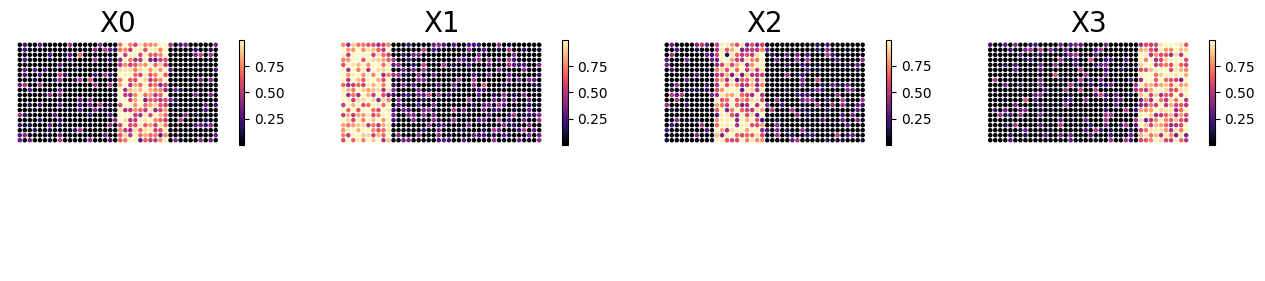

In [7]:
celltype_visualization_ST(pred_p=df_deconvolution_results.iloc[:, 3:], pos_all=df_deconvolution_results.iloc[:, 1:3], col_num=4)

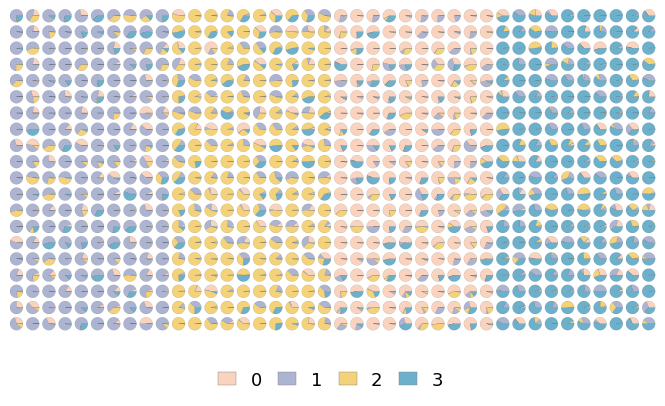

In [8]:
 pie_plot(pred_p=df_deconvolution_results.iloc[:, 3:], pos_all=df_deconvolution_results.iloc[:, 1:3])

# 5. Cell type matching

In [9]:
# read the sc data and calculate the mena expression of each cell type.
sc_data_path = data_dir + 'sc_data.h5'
df_sc_data = pd.read_hdf(sc_data_path, key='df')
df_gt_expr = calc_cell_type_expr(df_sc_data, save_dir)

### Function input
&nbsp;&nbsp;&nbsp;&nbsp;**df_sc**: (dataframe), shape: (cell_type_num, n_genes). The mean expression of each cell type in the sc data. 

&nbsp;&nbsp;&nbsp;&nbsp;**df_beta**:  (dataframe), shape: (cell_type_number, (n_genes + 1)). The deconvolved gene expressions of each cell type.  
### Function output
&nbsp;&nbsp;&nbsp;&nbsp;**df_matching_results**: (dataframe), shape: (cell_type_num, 2). The matching results between deconvolved cell types and the ground truth cell types. The index name is the ground truth cell types. The first column is the corresponding deconvolved cell types matched to each ground truth type. The second column displays the Pearson correlation coefficients between the ground truth cell types and their corresponding deconvolved cell types.

&nbsp;&nbsp;&nbsp;&nbsp;**df_corr**: (dataframe), shape: (cell_type_number, cell_type_number). The Pearson correlation matrix between ground truth cell types and deconvolved cell types.

In [10]:
df_matching_results, df_corr = cell_type_matching(df_sc=df_gt_expr, df_beta=df_beta)

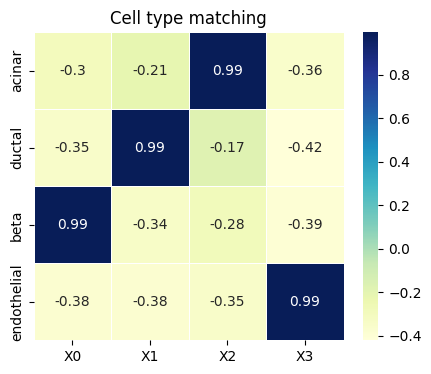

In [11]:
plt.figure(figsize=(5, 4))
sns.heatmap(df_corr, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title('Cell type matching')
plt.show()